# Predicting a Patient's Succesful Completion of Drug Treatment Program

We are using 2011 nationwide data of patients discharged from drug treatment programs (either through completion of the program or by dropping out). The goal is to analyse some of the attributes of the patient or their circumstances to see if they may have some impact on the outcome of whether the patient completes treatment or drops out against professional advice.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# Read in and clean some of the data 

In [2]:
df_raw = pd.read_table('Discharge_Data.tsv')

We need to subset our data to the observations where the REASON for discharge from the program was either:

1: Treatment Completed, or 

2: Left Against Professional Advice

In [3]:
df = df_raw.loc[df_raw['REASON'].isin([1,2])]

Since -9 represents NA/mising values in the dataset, map to NaN for easier reading and computation with pandas/numpy.
Also, convert outcome variable REASON to binary 0,1 for easier computation:

In [4]:
df = df.replace(-9, np.nan)
df['REASON'] = df['REASON'].replace(2, 0)

In previewing the data below, there are 65 variables including the outcome. We need to pick only a handful to analyse in our model to ensure it is manageable and to prevent overfitting.

In [5]:
df.head()

,CASEID,DISYR,AGE,GENDER,RACE,ETHNIC,MARSTAT,EDUC,EMPLOY,DETNLF,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,ALCDRUG,DSMCRIT,PSYPROB,HLTHINS,PRIMPAY
2,3,2011,11,1.0,5.0,5.0,3.0,4.0,4.0,3.0,...,0,0,0,0,0,3,13.0,2.0,NaN,9.0
3,4,2011,6,2.0,5.0,5.0,3.0,4.0,3.0,NaN,...,0,0,0,0,0,2,NaN,1.0,4.0,5.0
4,5,2011,9,2.0,5.0,5.0,4.0,3.0,1.0,NaN,...,0,0,0,0,0,1,9.0,1.0,4.0,5.0
5,6,2011,5,1.0,4.0,5.0,1.0,4.0,4.0,6.0,...,0,0,0,0,0,2,NaN,2.0,4.0,8.0
6,7,2011,6,1.0,5.0,5.0,1.0,3.0,2.0,NaN,...,0,0,0,0,0,2,7.0,2.0,NaN,1.0


As displayed above, most of the data is categorical but represented by a numerical value. The variables I plan to include in the model are dictated below:

Variable | Description | Type of Variable
---| ---| ---
AGE | (Values 2-11) Mapped to Age Ranges from 11 and under to 55+ | categorical
GENDER | 1 = Male, 2 = Female | categorical
EDUC | (Values 1-5) Mapped to Years of Education Ranges, from 8 and less to 16+ | categorical
EMPLOY | (Values 1-4) Mapped to Employment Status: FT, PT, Unemployed, Not in Labour Force | categorical
LIVARAG | (Values 1-3) Living Arrangement: Homeless, Independent, Dependent | categorical
LOS | Length of Stay # of days til 30 (after 30, ranges: 31 = 31-45 days, 32 = 46=60 days, etc.) | continuous/categorical 
PSOURCE | (Values 1-7) Primary Source of Referral | categorical
NOPRIOR | # of Prior Treatment Episodes | continuous
NUMSUBS | Number of Substances | continous
SUB1 | (Values 1-20) Mapped to Primary Substance of Abuse | categorical
REASON | 1 = Treatment Completed , 0 = Dropped Out | categorical

In [5]:
# subset data according to above variables
df = df[['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LIVARAG', 'LOS', 'PSOURCE', 'NOPRIOR', 'NUMSUBS', 'SUB1', 'REASON']].dropna()

# created version with mapped variables for easier comprehension, use unmapped version for charting ordinal variables
df_mapped = df.copy()

We can take a quick look at distributions of chosen variables - note despite all being categorical some are ordinal such as AGE, EDUC, LOS (Length of Stay), NOPRIOR (Number of Prior Treatments), NUMSUBS (Number of Substances):

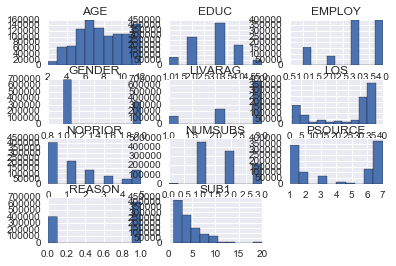

In [7]:
df.hist();

Focusing on the distribution of the AGE ranges between those who completed treatment and those who dropped out:

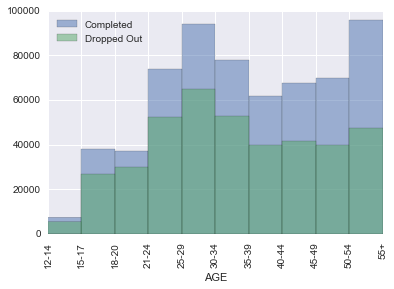

In [8]:
plt.hist(df[df['REASON'] == 1]['AGE'], alpha = 0.5, label = 'Completed')
plt.hist(df[df['REASON'] == 0]['AGE'], alpha = 0.5, label = 'Dropped Out')
plt.legend(loc = 'upper left');
x = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels =  ['12-14', '15-17', '18-20', '21-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55+']
plt.xticks(x, labels, rotation='vertical');
plt.xlabel('AGE');

It looks like there is a downward trend in those dropping out of the program as the age range increases, so it could age could be an indicative variable in our model. We can further analyse this in conjunction with gender to see if this is true across both sexes:

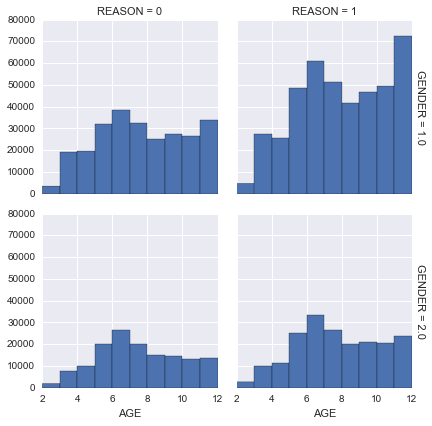

In [9]:
# Reason = 1: Completed Treatment, Reason = 2: Dropped Out
# Gender = 1: Male, Gender = 2: Female
g = sns.FacetGrid(df, row = 'GENDER', col = 'REASON', margin_titles = True)
g.map(plt.hist, 'AGE');

The majority of those who finish treatment are men older than 55+. Once again it looks like the distributions seem similar at first glance.

# Mapping Variables to Categorical Values for Models

Age Ranges:

In [6]:
AGE_Map = {1: '11 and Under',
           2: '12 to 14',
           3: '15 to 17',
           4: '18 to 20',
           5: '21 to 23',
           6: '25 to 29',
           7: '30 to 34',
           8: '35 to 39',
           9: '40 to 44',
           10: '45 to 49',
           11: '50 to 54',
           12: '55+'}

df_mapped['AGE'].replace(AGE_Map, inplace = True)

Gender:

In [7]:
GENDER_Map = {1: 'Male',
              2: 'Female'}
df_mapped['GENDER'].replace(GENDER_Map, inplace = True)

Education:

In [8]:
EDUC_Map = {1: '00 to 08',
            2: '09 to 11',
            3: '12 ',
            4: '13 to 15',
            5: '16+'}
df_mapped['EDUC'].replace(EDUC_Map, inplace = True)

Employment Status:

In [9]:
EMPLOY_Map = {1: 'Full Time',
              2: 'Part Time',
              3: 'Unemployed',
              4: 'Not in Labour Force'}
df_mapped['EMPLOY'].replace(EMPLOY_Map, inplace = True)

Living Arrangement:

In [10]:
LIVARAG_Map = {1: 'Homeless',
               2: 'Dependent',
               3: 'Independent'}
df_mapped['LIVARAG'].replace(LIVARAG_Map, inplace = True)

Length of Stay:

In [11]:
# mapping length of stay - although the data is continuous for stays 1-30 days, the rest of the lengths are measured in range
LOS_map = {31: '31-45',
           32: '46-60',
           33: '61-90',
           34: '90-120',
           35: '121-180',
           36: '181-365',
           37: '365+'
           }
df_mapped['LOS'].replace(LOS_map, inplace = True)
df_mapped['LOS'] = np.where(df_mapped.LOS.isin(range(1,16)), '1-15', df_mapped['LOS'])
df_mapped['LOS'] = np.where(df_mapped.LOS.isin(range(16,31)), '16-30', df_mapped['LOS'])

Principal Source of Referral:

In [12]:
PSOURCE_Map = {1: 'Individual',
               2: 'Drug Abuse Provider',
               3: 'Other Health Provider',
               4: 'School',
               5: 'Employer',
               6: 'Other Community Referral',
               7: 'Court'}
df_mapped['PSOURCE'].replace(PSOURCE_Map, inplace = True)

Primary Drug Used:

In [14]:
# mapping primary drug used - since there are 20 unique categories, take the 6 most common and code the rest as 'Other'
df_mapped['SUB1'].value_counts(ascending = False)

2.0     415986
4.0     194717
5.0     143348
7.0      81976
3.0      81417
10.0     70587
13.0      8517
20.0      6876
1.0       5412
11.0      4852
8.0       3114
6.0       2996
16.0      1369
9.0        959
18.0       693
17.0       683
12.0       662
15.0       502
14.0       230
Name: SUB1, dtype: int64

In [13]:
# mapping substances
SUB1_Map = {2: 'Alcohol',
            3: 'Crack Cocaine',
            4: 'Marijuana',
            5: 'Heroine',
            7: 'Opiates Synthetics',
            10: 'Meth'}
df_mapped['SUB1'].replace(SUB1_Map, inplace = True)
df_mapped['SUB1'] = np.where(df_mapped.SUB1.isin([1,6,8,9,11,12,13,14,15,16,17,18,18,20]), 'Other', df_mapped['SUB1'])

# Look at Distributions of the Mapped [Categorical] Data

In [27]:
features = ['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LIVARAG', 'LOS', 'PSOURCE', 'SUB1']

for feature in features:
    print pd.crosstab(index = df_mapped[feature], columns = df_mapped['REASON'], normalize = 'index'), '\n'

REASON           0         1
AGE                         
12 to 14  0.423148  0.576852
15to 17   0.414261  0.585739
18 to 20  0.443965  0.556035
21 to 23  0.414726  0.585274
25 to 29  0.407208  0.592792
30 to 34  0.403946  0.596054
35 to 39  0.392508  0.607492
40 to 44  0.381801  0.618199
45 to 49  0.362967  0.637033
50 to 54  0.341443  0.658557
55+       0.318304  0.681696 

REASON         0         1
GENDER                    
Female  0.423676  0.576324
Male    0.375298  0.624702 

REASON                  0         1
EDUC                               
12               0.378444  0.621556
13 to 15         0.354772  0.645228
16 or More       0.291284  0.708716
8 Years or Less  0.423015  0.576985
9 to 11          0.447220  0.552780 

REASON                      0         1
EMPLOY                                 
Full Time            0.304637  0.695363
Not in Labour Force  0.399741  0.600259
Part Time            0.377235  0.622765
Unemployed           0.419624  0.580376 

REASON         

In [14]:
df_mapped.head()

,AGE,GENDER,EDUC,EMPLOY,LIVARAG,LOS,PSOURCE,NOPRIOR,NUMSUBS,SUB1,REASON
3,25 to 29,Female,13 to 15,Unemployed,Independent,46-60,Individual,1.0,2,Opiates Synthetics,0
4,40 to 44,Female,12,Full Time,Independent,16-30,Other Community Referral,3.0,1,Alcohol,1
6,25 to 29,Male,12,Part Time,Independent,121-180,Court,2.0,1,Marijuana,1
7,25 to 29,Male,13 to 15,Not in Labour Force,Homeless,1-15,Individual,5.0,2,Heroine,0
8,35 to 39,Male,16 or More,Full Time,Independent,181-365,Individual,3.0,2,Meth,1


In [14]:
dummies = pd.get_dummies(df_mapped[['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LIVARAG', 'LOS', 'PSOURCE', 'SUB1']], drop_first = True)

In [15]:
df_mapped1 = df_mapped.join(dummies)

In [16]:
y = df_mapped1['REASON']
X = df_mapped1.drop(['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LOS', 'LIVARAG', 'PSOURCE', 'SUB1', 'REASON'], axis = 1, inplace = False)

from sklearn import linear_model
logr = linear_model.LogisticRegression()
logr.fit(X,y)

C:\Users\Caroline\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
cv = StratifiedKFold(y, n_folds = 5, shuffle = True, random_state = 3)
perf = cross_val_score(logr, X, y, cv=cv, scoring = "accuracy")
print perf.mean(), perf.std()

0.629696082689 0.000908804980133


In [23]:
len(df_mapped[df_mapped.REASON == 1])/np.float32(len(df_mapped))

0.60877201198950914

Our model is performing with 63% accuracy; given a baseline performance of 60.8% this is not a strong model. We can use gridsearch to see if changing parameters will improve our accuracy:

In [28]:
logr = linear_model.LogisticRegression()
params = {"C": [0.000001, 0.001, 1, 100, 10000], "penalty": ["l1", "l2"]}

from sklearn.grid_search import GridSearchCV
logr_grid = GridSearchCV(logr, params, n_jobs =-1, verbose = False, cv=cv)
df_sub = df_mapped1.sample(frac = 0.1)
X_sub = df_sub.drop(['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LOS', 'LIVARAG', 'PSOURCE', 'SUB1', 'REASON'], axis = 1, inplace = False)
y_sub = df_sub['REASON']
logr_grid.fit(X_sub,y_sub)

C:\Users\Caroline\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


JoblibIndexError: JoblibIndexError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\Caroline\Anaconda2\lib\runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = r'C:\Users\Caroline\Anaconda2\lib\site-packages\ipykernel\__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
C:\Users\Caroline\Anaconda2\lib\runpy.py in _run_code(code=<code object <module> at 0000000002865B30, file ...lib\site-packages\ipykernel\__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': r'C:\Users\Caroline\Anaconda2\lib\site-packages\ipykernel\__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from 'C:\Users\Car...onda2\lib\site-packages\ipykernel\kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname=r'C:\Users\Caroline\Anaconda2\lib\site-packages\ipykernel\__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0000000002865B30, file ...lib\site-packages\ipykernel\__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': r'C:\Users\Caroline\Anaconda2\lib\site-packages\ipykernel\__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from 'C:\Users\Car...onda2\lib\site-packages\ipykernel\kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\ipykernel\__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    591         
    592         If a global instance already exists, this reinitializes and starts it
    593         """
    594         app = cls.instance(**kwargs)
    595         app.initialize(argv)
--> 596         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    597 
    598 #-----------------------------------------------------------------------------
    599 # utility functions, for convenience
    600 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    437         
    438         if self.poller is not None:
    439             self.poller.start()
    440         self.kernel.start()
    441         try:
--> 442             ioloop.IOLoop.instance().start()
    443         except KeyboardInterrupt:
    444             pass
    445 
    446 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'logr = linear_model.LogisticRegression()\npara...= df_sub[\'REASON\']\nlogr_grid.fit(X_sub,y_sub)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-11-23T15:20:56.051000', u'msg_id': u'E78513DC8EF14390A391AA61F6B34196', u'msg_type': u'execute_request', u'session': u'26582A89FCFE44A9A5130D7F2E77ECD8', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'E78513DC8EF14390A391AA61F6B34196', 'msg_type': u'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['26582A89FCFE44A9A5130D7F2E77ECD8']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'logr = linear_model.LogisticRegression()\npara...= df_sub[\'REASON\']\nlogr_grid.fit(X_sub,y_sub)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-11-23T15:20:56.051000', u'msg_id': u'E78513DC8EF14390A391AA61F6B34196', u'msg_type': u'execute_request', u'session': u'26582A89FCFE44A9A5130D7F2E77ECD8', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'E78513DC8EF14390A391AA61F6B34196', 'msg_type': u'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['26582A89FCFE44A9A5130D7F2E77ECD8'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'logr = linear_model.LogisticRegression()\npara...= df_sub[\'REASON\']\nlogr_grid.fit(X_sub,y_sub)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2016-11-23T15:20:56.051000', u'msg_id': u'E78513DC8EF14390A391AA61F6B34196', u'msg_type': u'execute_request', u'session': u'26582A89FCFE44A9A5130D7F2E77ECD8', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'E78513DC8EF14390A391AA61F6B34196', 'msg_type': u'execute_request', 'parent_header': {}})
    386         if not silent:
    387             self.execution_count += 1
    388             self._publish_execute_input(code, parent, self.execution_count)
    389 
    390         reply_content = self.do_execute(code, silent, store_history,
--> 391                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    392 
    393         # Flush output before sending the reply.
    394         sys.stdout.flush()
    395         sys.stderr.flush()

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'logr = linear_model.LogisticRegression()\npara...= df_sub[\'REASON\']\nlogr_grid.fit(X_sub,y_sub)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    194 
    195         reply_content = {}
    196         # FIXME: the shell calls the exception handler itself.
    197         shell._reply_content = None
    198         try:
--> 199             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'logr = linear_model.LogisticRegression()\npara...= df_sub[\'REASON\']\nlogr_grid.fit(X_sub,y_sub)'
        store_history = True
        silent = False
    200         except:
    201             status = u'error'
    202             # FIXME: this code right now isn't being used yet by default,
    203             # because the run_cell() call above directly fires off exception

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'logr = linear_model.LogisticRegression()\npara...= df_sub[\'REASON\']\nlogr_grid.fit(X_sub,y_sub)', store_history=True, silent=False, shell_futures=True)
   2718                 self.displayhook.exec_result = result
   2719 
   2720                 # Execute the user code
   2721                 interactivity = "none" if silent else self.ast_node_interactivity
   2722                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2723                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2724 
   2725                 # Reset this so later displayed values do not modify the
   2726                 # ExecutionResult
   2727                 self.displayhook.exec_result = None

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-28-daa62441c292>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2826                     return True
   2827 
   2828             for i, node in enumerate(to_run_interactive):
   2829                 mod = ast.Interactive([node])
   2830                 code = compiler(mod, cell_name, "single")
-> 2831                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 000000001350B930, file "<ipython-input-28-daa62441c292>", line 9>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2832                     return True
   2833 
   2834             # Flush softspace
   2835             if softspace(sys.stdout, 0):

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 000000001350B930, file "<ipython-input-28-daa62441c292>", line 9>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2880         outflag = 1  # happens in more places, so it's easier as default
   2881         try:
   2882             try:
   2883                 self.hooks.pre_run_code_hook()
   2884                 #rprint('Running code', repr(code_obj)) # dbg
-> 2885                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 000000001350B930, file "<ipython-input-28-daa62441c292>", line 9>
        self.user_global_ns = {'AGE_Map': {1: '11 and Under', 2: '12 to 14', 3: '15to 17', 4: '18 to 20', 5: '21 to 23', 6: '25 to 29', 7: '30 to 34', 8: '35 to 39', 9: '40 to 44', 10: '45 to 49', ...}, 'EDUC_Map': {1: '8 Years or Less', 2: '9 to 11', 3: '12', 4: '13 to 15', 5: '16 or More'}, 'EMPLOY_Map': {1: 'Full Time', 2: 'Part Time', 3: 'Unemployed', 4: 'Not in Labour Force'}, 'GENDER_Map': {1: 'Male', 2: 'Female'}, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', u"import pandas as pd\nimport numpy as np\nimpor...lotlib inline')\nimport matplotlib.pyplot as plt", u"df_raw = pd.read_table('Discharge_Data.tsv')", u"df = df_raw.loc[df_raw['REASON'].isin([1,2])]", u"df = df.replace(-9, np.nan)\ndf['REASON'] = df['REASON'].replace(2, 0)", u"# subset data according to above variables\ndf...harting ordinal variables\ndf_mapped = df.copy()", u"AGE_Map = {1: '11 and Under',\n           2: '...f_mapped['AGE'].replace(AGE_Map, inplace = True)", u"GENDER_Map = {1: 'Male',\n              2: 'Fe...ed['GENDER'].replace(GENDER_Map, inplace = True)", u"# mapping education\nEDUC_Map = {1: '8 Years o...mapped['EDUC'].replace(EDUC_Map, inplace = True)", u"# mapping employment status\nEMPLOY_Map = {1: ...ed['EMPLOY'].replace(EMPLOY_Map, inplace = True)", u"# mapping living arrangement status\nLIVARAG_M...['LIVARAG'].replace(LIVARAG_Map, inplace = True)", u"# mapping length of stay - although the data i...S.isin(range(16,31)), '16-30', df_mapped['LOS'])", u"# mapping principal source of referral\nPSOURC...['PSOURCE'].replace(PSOURCE_Map, inplace = True)", u"# mapping substances\nSUB1_Map = {2: 'Alcohol'...15,16,17,18,18,20]), 'Other', df_mapped['SUB1'])", u"dummies = pd.get_dummies(df_mapped[['AGE', 'GE..., 'LOS', 'PSOURCE', 'SUB1']], drop_first = True)", u'df_mapped1 = df_mapped.join(dummies)', u"y = df_mapped1['REASON']\nX = df_mapped1.drop(...linear_model.LogisticRegression()\nlogr.fit(X,y)", u'from sklearn.cross_validation import cross_val...ing = "accuracy")\nprint perf.mean(), perf.std()', u"features = df_mapped[['AGE', 'GENDER', 'EDUC',...['REASON'], normalize = 'index', margins = True)", u"features = ['AGE', 'GENDER', 'EDUC', 'EMPLOY',...['REASON'], normalize = 'index', margins = True)", ...], 'KFold': <class 'sklearn.cross_validation.KFold'>, 'LIVARAG_Map': {1: 'Homeless', 2: 'Dependent', 3: 'Independent'}, 'LOS_map': {31: '31-45', 32: '46-60', 33: '61-90', 34: '90-120', 35: '121-180', 36: '181-365', 37: '365+'}, 'Out': {16: LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False)}, ...}
        self.user_ns = {'AGE_Map': {1: '11 and Under', 2: '12 to 14', 3: '15to 17', 4: '18 to 20', 5: '21 to 23', 6: '25 to 29', 7: '30 to 34', 8: '35 to 39', 9: '40 to 44', 10: '45 to 49', ...}, 'EDUC_Map': {1: '8 Years or Less', 2: '9 to 11', 3: '12', 4: '13 to 15', 5: '16 or More'}, 'EMPLOY_Map': {1: 'Full Time', 2: 'Part Time', 3: 'Unemployed', 4: 'Not in Labour Force'}, 'GENDER_Map': {1: 'Male', 2: 'Female'}, 'GridSearchCV': <class 'sklearn.grid_search.GridSearchCV'>, 'In': ['', u"import pandas as pd\nimport numpy as np\nimpor...lotlib inline')\nimport matplotlib.pyplot as plt", u"df_raw = pd.read_table('Discharge_Data.tsv')", u"df = df_raw.loc[df_raw['REASON'].isin([1,2])]", u"df = df.replace(-9, np.nan)\ndf['REASON'] = df['REASON'].replace(2, 0)", u"# subset data according to above variables\ndf...harting ordinal variables\ndf_mapped = df.copy()", u"AGE_Map = {1: '11 and Under',\n           2: '...f_mapped['AGE'].replace(AGE_Map, inplace = True)", u"GENDER_Map = {1: 'Male',\n              2: 'Fe...ed['GENDER'].replace(GENDER_Map, inplace = True)", u"# mapping education\nEDUC_Map = {1: '8 Years o...mapped['EDUC'].replace(EDUC_Map, inplace = True)", u"# mapping employment status\nEMPLOY_Map = {1: ...ed['EMPLOY'].replace(EMPLOY_Map, inplace = True)", u"# mapping living arrangement status\nLIVARAG_M...['LIVARAG'].replace(LIVARAG_Map, inplace = True)", u"# mapping length of stay - although the data i...S.isin(range(16,31)), '16-30', df_mapped['LOS'])", u"# mapping principal source of referral\nPSOURC...['PSOURCE'].replace(PSOURCE_Map, inplace = True)", u"# mapping substances\nSUB1_Map = {2: 'Alcohol'...15,16,17,18,18,20]), 'Other', df_mapped['SUB1'])", u"dummies = pd.get_dummies(df_mapped[['AGE', 'GE..., 'LOS', 'PSOURCE', 'SUB1']], drop_first = True)", u'df_mapped1 = df_mapped.join(dummies)', u"y = df_mapped1['REASON']\nX = df_mapped1.drop(...linear_model.LogisticRegression()\nlogr.fit(X,y)", u'from sklearn.cross_validation import cross_val...ing = "accuracy")\nprint perf.mean(), perf.std()', u"features = df_mapped[['AGE', 'GENDER', 'EDUC',...['REASON'], normalize = 'index', margins = True)", u"features = ['AGE', 'GENDER', 'EDUC', 'EMPLOY',...['REASON'], normalize = 'index', margins = True)", ...], 'KFold': <class 'sklearn.cross_validation.KFold'>, 'LIVARAG_Map': {1: 'Homeless', 2: 'Dependent', 3: 'Independent'}, 'LOS_map': {31: '31-45', 32: '46-60', 33: '61-90', 34: '90-120', 35: '121-180', 36: '181-365', 37: '365+'}, 'Out': {16: LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False)}, ...}
   2886             finally:
   2887                 # Reset our crash handler in place
   2888                 sys.excepthook = old_excepthook
   2889         except SystemExit as e:

...........................................................................
C:\Users\Caroline\GitStuff\ds-homework\<ipython-input-28-daa62441c292> in <module>()
      4 from sklearn.grid_search import GridSearchCV
      5 logr_grid = GridSearchCV(logr, params, n_jobs =-1, verbose = True, cv=cv)
      6 df_sub = df_mapped1.sample(frac = 0.1)
      7 X_sub = df_sub.drop(['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LOS', 'LIVARAG', 'PSOURCE', 'SUB1', 'REASON'], axis = 1, inplace = False)
      8 y_sub = df_sub['REASON']
----> 9 logr_grid.fit(X_sub,y_sub)
     10 
     11 
     12 
     13 

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\sklearn\grid_search.py in fit(self=GridSearchCV(cv=sklearn.cross_validation.Stratif...*n_jobs', refit=True, scoring=None, verbose=True), X=         NOPRIOR  NUMSUBS  AGE_15to 17  AGE_18 t...660111          0.0  

[102490 rows x 42 columns], y=539557     1
1465128    1
1091784    1
1520858  ...881     0
660111     1
Name: REASON, dtype: int64)
    824         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    825             Target relative to X for classification or regression;
    826             None for unsupervised learning.
    827 
    828         """
--> 829         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method GridSearchCV._fit of GridSearchCV(...n_jobs', refit=True, scoring=None, verbose=True)>
        X =          NOPRIOR  NUMSUBS  AGE_15to 17  AGE_18 t...660111          0.0  

[102490 rows x 42 columns]
        y = 539557     1
1465128    1
1091784    1
1520858  ...881     0
660111     1
Name: REASON, dtype: int64
        self.param_grid = {'C': [1e-06, 0.001, 1, 100, 10000], 'penalty': ['l1', 'l2']}
    830 
    831 
    832 class RandomizedSearchCV(BaseSearchCV):
    833     """Randomized search on hyper parameters.

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\sklearn\grid_search.py in _fit(self=GridSearchCV(cv=sklearn.cross_validation.Stratif...*n_jobs', refit=True, scoring=None, verbose=True), X=         NOPRIOR  NUMSUBS  AGE_15to 17  AGE_18 t...660111          0.0  

[102490 rows x 42 columns], y=539557     1
1465128    1
1091784    1
1520858  ...881     0
660111     1
Name: REASON, dtype: int64, parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    568         )(
    569             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    570                                     train, test, self.verbose, parameters,
    571                                     self.fit_params, return_parameters=True,
    572                                     error_score=self.error_score)
--> 573                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    574                 for train, test in cv)
    575 
    576         # Out is a list of triplet: score, estimator, n_test_samples
    577         n_fits = len(out)

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
IndexError                                         Wed Nov 23 15:21:43 2016
PID: 8012             Python 2.7.12: C:\Users\Caroline\Anaconda2\python.exe
...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (LogisticRegression(C=1e-06, class_weight=None, d...ol=0.0001,
          verbose=0, warm_start=False),          NOPRIOR  NUMSUBS  AGE_15to 17  AGE_18 t...660111          0.0  

[102490 rows x 42 columns], 539557     1
1465128    1
1091784    1
1520858  ...881     0
660111     1
Name: REASON, dtype: int64, <function _passthrough_scorer>, memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895]), array([      0,       1,       6, ..., 1024889, 1024891, 1024894]), True, {'C': 1e-06, 'penalty': 'l1'}, {})
        kwargs = {'error_score': 'raise', 'return_parameters': True}
        self.items = [(<function _fit_and_score>, (LogisticRegression(C=1e-06, class_weight=None, d...ol=0.0001,
          verbose=0, warm_start=False),          NOPRIOR  NUMSUBS  AGE_15to 17  AGE_18 t...660111          0.0  

[102490 rows x 42 columns], 539557     1
1465128    1
1091784    1
1520858  ...881     0
660111     1
Name: REASON, dtype: int64, <function _passthrough_scorer>, memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895]), array([      0,       1,       6, ..., 1024889, 1024891, 1024894]), True, {'C': 1e-06, 'penalty': 'l1'}, {}), {'error_score': 'raise', 'return_parameters': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\sklearn\cross_validation.py in _fit_and_score(estimator=LogisticRegression(C=1e-06, class_weight=None, d...ol=0.0001,
          verbose=0, warm_start=False), X=         NOPRIOR  NUMSUBS  AGE_15to 17  AGE_18 t...660111          0.0  

[102490 rows x 42 columns], y=539557     1
1465128    1
1091784    1
1520858  ...881     0
660111     1
Name: REASON, dtype: int64, scorer=<function _passthrough_scorer>, train=memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895]), test=array([      0,       1,       6, ..., 1024889, 1024891, 1024894]), verbose=True, parameters={'C': 1e-06, 'penalty': 'l1'}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1653     if parameters is not None:
   1654         estimator.set_params(**parameters)
   1655 
   1656     start_time = time.time()
   1657 
-> 1658     X_train, y_train = _safe_split(estimator, X, y, train)
        X_train = undefined
        y_train = undefined
        estimator = LogisticRegression(C=1e-06, class_weight=None, d...ol=0.0001,
          verbose=0, warm_start=False)
        X =          NOPRIOR  NUMSUBS  AGE_15to 17  AGE_18 t...660111          0.0  

[102490 rows x 42 columns]
        y = 539557     1
1465128    1
1091784    1
1520858  ...881     0
660111     1
Name: REASON, dtype: int64
        train = memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895])
   1659     X_test, y_test = _safe_split(estimator, X, y, test, train)
   1660 
   1661     try:
   1662         if y_train is None:

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\sklearn\cross_validation.py in _safe_split(estimator=LogisticRegression(C=1e-06, class_weight=None, d...ol=0.0001,
          verbose=0, warm_start=False), X=         NOPRIOR  NUMSUBS  AGE_15to 17  AGE_18 t...660111          0.0  

[102490 rows x 42 columns], y=539557     1
1465128    1
1091784    1
1520858  ...881     0
660111     1
Name: REASON, dtype: int64, indices=memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895]), train_indices=None)
   1721             if train_indices is None:
   1722                 X_subset = X[np.ix_(indices, indices)]
   1723             else:
   1724                 X_subset = X[np.ix_(indices, train_indices)]
   1725         else:
-> 1726             X_subset = safe_indexing(X, indices)
        X_subset = undefined
        X =          NOPRIOR  NUMSUBS  AGE_15to 17  AGE_18 t...660111          0.0  

[102490 rows x 42 columns]
        indices = memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895])
   1727 
   1728     if y is not None:
   1729         y_subset = safe_indexing(y, indices)
   1730     else:

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\sklearn\utils\__init__.py in safe_indexing(X=         NOPRIOR  NUMSUBS  AGE_15to 17  AGE_18 t...660111          0.0  

[102490 rows x 42 columns], indices=memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895]))
     94         Indices according to which X will be subsampled.
     95     """
     96     if hasattr(X, "iloc"):
     97         # Pandas Dataframes and Series
     98         try:
---> 99             return X.iloc[indices]
        X.iloc = <pandas.core.indexing._iLocIndexer object>
        indices = memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895])
    100         except ValueError:
    101             # Cython typed memoryviews internally used in pandas do not support
    102             # readonly buffers.
    103             warnings.warn("Copying input dataframe for slicing.",

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\pandas\core\indexing.py in __getitem__(self=<pandas.core.indexing._iLocIndexer object>, key=memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895]))
   1291             key = com._apply_if_callable(key, self.obj)
   1292 
   1293         if type(key) is tuple:
   1294             return self._getitem_tuple(key)
   1295         else:
-> 1296             return self._getitem_axis(key, axis=0)
        self._getitem_axis = <bound method _iLocIndexer._getitem_axis of <pandas.core.indexing._iLocIndexer object>>
        key = memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895])
   1297 
   1298     def _getitem_axis(self, key, axis=0):
   1299         raise NotImplementedError()
   1300 

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\pandas\core\indexing.py in _getitem_axis(self=<pandas.core.indexing._iLocIndexer object>, key=memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895]), axis=0)
   1594         else:
   1595 
   1596             if is_list_like_indexer(key):
   1597 
   1598                 # validate list bounds
-> 1599                 self._is_valid_list_like(key, axis)
        self._is_valid_list_like = <bound method _iLocIndexer._is_valid_list_like of <pandas.core.indexing._iLocIndexer object>>
        key = memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895])
        axis = 0
   1600 
   1601                 # force an actual list
   1602                 key = list(key)
   1603 

...........................................................................
C:\Users\Caroline\Anaconda2\lib\site-packages\pandas\core\indexing.py in _is_valid_list_like(self=<pandas.core.indexing._iLocIndexer object>, key=memmap([      2,       3,       4, ..., 1024892, 1024893, 1024895]), axis=0)
   1533         # coerce the key to not exceed the maximum size of the index
   1534         arr = np.array(key)
   1535         ax = self.obj._get_axis(axis)
   1536         l = len(ax)
   1537         if len(arr) and (arr.max() >= l or arr.min() < -l):
-> 1538             raise IndexError("positional indexers are out-of-bounds")
   1539 
   1540         return True
   1541 
   1542     def _getitem_tuple(self, tup):

IndexError: positional indexers are out-of-bounds
___________________________________________________________________________

102490

In [ ]:
print logr_grid.best_params_
print logr_grid.best_score_

In [37]:
print logr.get_params, logr.coef_

AttributeError: 'LogisticRegression' object has no attribute 'params_'

Use Recursive Feature Elimination to see if we can hone in on some attributes to rebuild a logr model

In [ ]:
from sklearn.feature_selection import RFE
rfe = RFE(logr, 10)
rfe = rfe.fit(X,y)
print (rfe.support_)
print(rfe.ranking_)

In [33]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
X = df_mapped1.drop(['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LOS', 'LIVARAG', 'PSOURCE', 'SUB1', 'REASON'], axis = 1, inplace = False)
y = df_mapped1['REASON']
dt.fit(X,y)

perf = cross_val_score(dt, X, y, cv=cv)
print perf.mean(), perf.std()

0.609786748069 0.000391068126362


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X,y)
print(model.feature_importances)